In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import datetime
import seaborn as sns
from shapely import wkb
from shapely.geometry import Point
from shapely.geometry import LineString
import geopandas as gp
import matplotlib.pyplot as plt
%matplotlib inline

In [210]:
df = pd.read_csv('./data/mr.csv', sep='\;')

<ipython-input-210-01c789eb6329>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./data/mr.csv', sep='\;')


In [211]:
df

,id,opath,cpath,mgeom,length
0,0,"296,296,296,296,296",296,"LINESTRING(51.3473271634 35.7388015917,51.3473...","0.000158953703954,0.000158953703954,0.00015895..."
1,0,"457,159,483,458,251","457,159,484,295,483,458,251","LINESTRING(51.3469343763 35.7380099486,51.3469...","0.000109404570288,9.47900838666e-05,8.61376804..."
2,0,"297,252,488,494,495","297,487,256,252,488,489,298,490,491,249,492,49...","LINESTRING(51.3476502132 35.7390303435,51.3476...","0.000222635352092,0.00016668284255,0.000164539..."
3,4,"159,296,297,490,492","159,484,295,483,458,251,485,296,486,297,487,25...","LINESTRING(51.3469338 35.738073,51.3469398 35....","9.47900838666e-05,0.000158953703954,0.00022263..."
4,0,"295,458,458,458,458","295,483,458","LINESTRING(51.3469592 35.7382483,51.3469763 35...","7.79975640658e-05,0.000145941632164,0.00014594..."
5,7,"297,488,488,300,496","297,487,256,252,488,489,298,490,491,249,492,49...","LINESTRING(51.347654812 35.73903346,51.3476652...","0.000222635352092,0.00016453923544,0.000164539..."


<ipython-input-14-989adeb903c8>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  matches = pd.read_csv('./data/mr.csv', sep='\;')


In [15]:
edges = gp.read_file('./ground-map/map/edges.shp')

In [16]:
trajectories = gp.read_file('./data/trajectories/trajs.shp')

<Figure size 6000x4000 with 0 Axes>

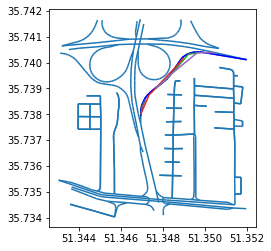

In [35]:
plt.figure(dpi=1000)
edges.plot()
ploted_edges = []
for i in range(len(matches)):
    edge_ids = matches.iloc[i]['cpath'].split(',')
    for edge_id in edge_ids:
        if edge_id in ploted_edges:
            continue
        ploted_edges.append(edge_id)
        edge = edges[(edges['id']==int(edge_id))]['geometry'].iloc[0]
        a = np.array(edge.coords)[:, 0]
        b = np.array(edge.coords)[:, 1]
        plt.plot(a, b, c='b')

for i in range(len(trajectories)):
    traj = trajectories['geometry'].iloc[i]
    a = np.array(traj.coords)[:, 0]
    b = np.array(traj.coords)[:, 1]
    plt.plot(a, b)

plt.savefig('matches.png')

In [3]:
edge = df[(df['id']==458)]['geometry'].iloc[0]

In [4]:
df1 = gp.read_file('./data/trajectories/trajs.shp')

In [5]:
traj = df1['geometry'].iloc[0]

In [10]:
np.array(traj.coords)[:, 0]

array([51.34694 , 51.34695 , 51.347008, 51.347107, 51.347134])

In [11]:
a = np.array(edge.coords)[:, 0]
b = np.array(edge.coords)[:, 1]
a1 = np.array(traj.coords)[:, 0]
b1 = np.array(traj.coords)[:, 1]

In [192]:
a = [x[0] for x in edge.coords]
b = [x[1] for x in edge.coords]
a1 = [x[0] for x in traj.coords]
b1 = [x[1] for x in traj.coords]

In [ ]:
for 

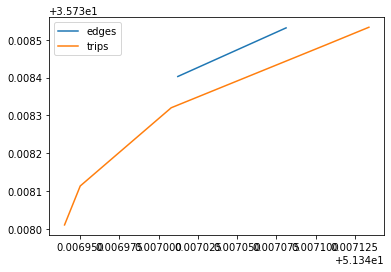

In [12]:
plt.plot(a, b, label='edges')
plt.plot(a1, b1, label='trips')
plt.legend()
plt.show()

In [158]:
print(a)
print(a1)
print(b)
print(b1)

[51.3472503, 51.3473745]
[51.34694, 51.34695, 51.347008, 51.347107, 51.347134]
[35.7387402, 35.7388394]
[35.73801, 35.738113, 35.73832, 35.738487, 35.738533]


In [216]:
print(df1['geometry'].iloc[5])

LINESTRING (51.34698 35.738228, 51.34705 35.73839, 51.347088 35.738453, 51.347088 35.738453, 51.347095 35.738464)


In [177]:
df1

,id,geometry
0,MfE6rZrZKr,"LINESTRING (51.34694 35.73801, 51.34695 35.738..."
1,Cl9qelgbwW,"LINESTRING (51.34735 35.73877, 51.34735 35.738..."
2,uQgVQWDDn3,"LINESTRING (51.34766 35.73901, 51.34828 35.739..."
3,4PsWDrmaMh,"LINESTRING (51.34694 35.73803, 51.34733 35.738..."
4,7DQedsmbuP,"LINESTRING (51.34767 35.73901, 51.34835 35.739..."
5,E8BB0hENGh,"LINESTRING (51.34698 35.73823, 51.34705 35.738..."


In [197]:
print(df1['geometry'].iloc[4])

LINESTRING (51.347668 35.739014, 51.348347 35.73952, 51.34839 35.73956, 51.34962 35.74038, 51.35043 35.740383)


In [201]:
mr = pd.read_csv('./data/mr.csv', sep=';')

In [205]:
mr['mgeom'].iloc[1]

'LINESTRING(51.347654812 35.73903346,51.3476652 35.7390405,51.3478913 35.739168,51.3481642 35.7393548,51.3482871 35.7394674,51.3484001 35.739587,51.3485263 35.7397368,51.3486302 35.73987,51.3487416 35.7400021,51.3488361 35.7401113,51.3488996 35.7401747,51.3489507 35.7402175,51.34904 35.7402691,51.349167 35.7403287,51.3493223 35.7403753,51.3494597 35.7404003,51.349608 35.740409,51.3497688 35.7404052,51.3498987 35.7403956,51.3504220015 35.7403242975)'

In [199]:
trips = gp.read_file('./sample-test/trips.shp')

In [200]:
trips

,id,geometry
0,1,"LINESTRING (1.65890 0.25099, 1.65494 0.70184, ..."
1,2,"LINESTRING (4.15042 1.60353, 3.47020 0.92331, ..."
2,3,"LINESTRING (0.20081 2.14089, 1.44262 2.14880, ..."
